In [15]:
import random
import numpy

import lang2vec.lang2vec as l2v

from typing import List

import torch
import torch.nn as nn
from torch.nn import functional as F


class LanguageMLP(nn.Module):
    def __init__(self, config, in_language_list: List[str], oov_language_list: List[str]):
        super(LanguageMLP, self).__init__()
        self.config = config
        self.do_onehot = config.one_hot
        self.in_language_list = in_language_list
        self.oov_language_list = oov_language_list
        self.l2v_cache = dict()
        self._cache_language_features()

        nl_project = config.nl_project
        in_features = len(self.in_language_list) + 1 + config.num_language_features if self.do_onehot else config.num_language_features
        self.nonlinear_project = nn.Linear(in_features, nl_project)
        self.down_project = nn.Linear(nl_project, config.low_rank_dim)
        self.activation = F.relu
        self.dropout = nn.Dropout(config.language_emb_dropout)

    def forward(self, lang_ids):

        lang_vector = self._encode_language_ids(lang_ids, self.do_onehot)

        lang_emb = self.nonlinear_project(torch.tensor(lang_vector).to(lang_ids.device))
        lang_emb = self.activation(lang_emb)
        lang_emb = self.down_project(lang_emb)
        lang_emb = self.dropout(lang_emb)
        return lang_emb

    def _encode_language_ids(self, language_id: int, do_onehot: bool = False) -> List[int]:

        # language one-hot vector
        # 0th id for UNK language
        # drop language_id
        one_hot = [0 for i in range(len(self.in_language_list) + 1)]
        if (random.random() < self.config.language_drop_rate) and self.training:
            one_hot[0] = 1
        elif language_id >= 1000:
            one_hot[0] = 1
        else:
            one_hot[language_id + 1] = 1

        # feature vector from lang2vec cache
        features = self.l2v_cache[self.in_language_list[language_id] if language_id < 1000 else self.oov_language_list[language_id-1000]]

        return features if not do_onehot else one_hot + features

    def _cache_language_features(self):

        features = dict()
        for lang in self.in_language_list + self.oov_language_list:
            features[lang] = l2v.get_features(l2v.LETTER_CODES[lang], self.config.language_features)[l2v.LETTER_CODES[lang]]
        self.l2v_cache = features


In [16]:
import random

import lang2vec.lang2vec as l2v

from typing import List

import torch
import torch.nn as nn
from torch.nn import functional as F


class LanguageEmbeddings(nn.Module):
    def __init__(self, config):
        super(LanguageEmbeddings, self).__init__()
        self.config = config

        self.language_emb = nn.Embedding(num_embeddings=config.num_languages, embedding_dim=config.low_rank_dim)
        self.dropout = nn.Dropout(config.language_emb_dropout)

    def forward(self, lang_ids):

        if lang_ids < 1000:
            lang_emb = self.language_emb(lang_ids.clone().detach())
            lang_emb = self.dropout(lang_emb)
        else:
            lang_emb = torch.mean(self.language_emb.weight, dim=0)

        return lang_emb.view(-1)

In [17]:
class Config(object):
    def __init__(self,
                 low_rank_dim: int = 32,
                 language_emb_dropout: float = 0.1,
                 one_hot: bool = False,
                 num_languages = 13,
                 num_language_features: int = 289,
                 nonlinear_project: int = 289,
                 language_drop_rate: float = 0.2,
                 language_features: str = "syntax_knn+phonology_knn+inventory_knn"):
        
        self.nl_project = nonlinear_project
        self.low_rank_dim = low_rank_dim
        self.language_emb_dropout = language_emb_dropout
        self.num_language_features = num_language_features
        self.num_languages = num_languages
        self.one_hot = one_hot
        self.language_drop_rate = language_drop_rate
        self.language_features = language_features

In [18]:
in_languages = '../languages/in-langs.txt'
oov_languages = '../languages/oov-langs.txt'
language_codes = '../languages/language_codes.txt'

config = Config()

in_lang_list = list()
with open(in_languages) as f:
    in_lang_list = [l.rstrip() for l in f]

oov_lang_list = list()
with open(oov_languages) as f:
    oov_lang_list = [l.rstrip() for l in f]
    
lang_codes = list()
with open(language_codes) as f:
    lang_codes = [l.rstrip() for l in f]
    
sorted(in_lang_list)
sorted(oov_lang_list)
hr = sorted(lang_codes[:13])
lr = sorted(lang_codes[13:])
lang_codes = hr + lr

In [19]:
language_mlp = LanguageMLP(config, in_lang_list, oov_lang_list)
language_mlp.load_state_dict(torch.load('../adapter.pgn.1/language_mlp.bin'))
language_mlp.eval()

LanguageMLP(
  (nonlinear_project): Linear(in_features=289, out_features=289, bias=True)
  (down_project): Linear(in_features=289, out_features=32, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [20]:
language_emb = LanguageEmbeddings(config)
language_emb.load_state_dict(torch.load('../adapter.rndinit.1/language_mlp.bin'))
language_emb.eval()

LanguageEmbeddings(
  (language_emb): Embedding(13, 32)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [21]:
in_language_feature = {lang: torch.tensor(language_mlp.l2v_cache[lang]) for lang in in_lang_list}
oov_language_feature = {lang: torch.tensor(language_mlp.l2v_cache[lang]) for lang in oov_lang_list}

In [22]:
import numpy as np

# ids = oov_lang_list.index('fi') + 1000
in_language_embedding = {lang: language_mlp(torch.tensor([in_lang_list.index(lang)])) for lang in in_lang_list}
oov_language_embedding = {lang: language_mlp(torch.tensor([oov_lang_list.index(lang)+1000])) for lang in oov_lang_list}
e2e_language_embedding = {lang: language_emb(torch.tensor([in_lang_list.index(lang)])) for lang in in_lang_list}

languages = list(in_language_embedding.keys()) + list(oov_language_embedding.keys())
embeddings = [emb.detach().numpy() for emb in in_language_embedding.values()] + [emb.detach().numpy() for emb in oov_language_embedding.values()]
features = [np.array(feat) for feat in in_language_feature.values()] + [np.array(feat) for feat in oov_language_feature.values()]

In [23]:
from sklearn.metrics import pairwise as p

lang_emb = numpy.array([in_language_embedding[lang].detach().numpy() for lang in sorted(in_language_embedding.keys())])
lang_feat = numpy.array([in_language_feature[lang].detach().numpy() for lang in sorted(in_language_feature.keys())])

lr_lang_emb = numpy.array([oov_language_embedding[lang].detach().numpy() for lang in sorted(oov_language_embedding.keys())])
lr_lang_feat = numpy.array([oov_language_feature[lang].detach().numpy() for lang in sorted(oov_language_feature.keys())])

all_lang_emb = np.concatenate((lang_emb, lr_lang_emb), axis=0)
all_lang_feat = np.concatenate((lang_feat, lr_lang_feat), axis=0)

e2e_emb = numpy.array([e2e_language_embedding[lang].detach().numpy() for lang in sorted(e2e_language_embedding.keys())])

d_emb = abs(1-abs(p.cosine_similarity(lang_emb)))
d_feat = 1-abs(p.cosine_similarity(lang_feat))
d_e2e = abs(1-abs(p.cosine_similarity(e2e_emb)))

lr_emb = abs(1-abs(p.cosine_similarity(lr_lang_emb)))
lr_feat = 1-abs(p.cosine_similarity(lr_lang_feat))

lr_d_emb = abs(1 - abs(p.cosine_similarity(lang_emb, lr_lang_emb)))
lr_d_feat = abs(1 - abs(p.cosine_similarity(lang_feat, lr_lang_feat)))

all_d_emb = abs(1-abs(p.cosine_similarity(all_lang_emb)))
all_d_feat = 1-abs(p.cosine_similarity(all_lang_feat))

print('features cos avg: {}'.format(np.sum(d_feat)/2/78))
print('embeddings avg: {}'.format(np.sum(d_emb)/2/78))
print('random init. avg: {}'.format(np.sum(d_e2e)/2/78))

print('LR feat cos avg: {}'.format(np.sum(lr_feat)/2/465))
print('LR emb cos avg: {}'.format(np.sum(lr_emb)/2/465))

print('LR-HR feat cos avg: {}'.format(np.mean(lr_d_feat)))
print('LR-HR emb cos avg: {}'.format(np.mean(lr_d_emb)))

print('ALL feat cos avg: {}'.format(np.sum(all_d_feat)/2/902))
print('ALL emb cos avg: {}'.format(np.sum(all_d_emb)/2/902))

print('features std: {}'.format(np.std(d_feat)))
print('embeddings std: {}'.format(np.std(d_emb)))
print('random init. std: {}'.format(np.std(d_e2e)))

print('LR feat cos std: {}'.format(np.std(lr_d_feat)))
print('LR emb cos std: {}'.format(np.std(lr_d_emb)))

#d_emb = p.euclidean_distances(lang_emb)
#d_feat = p.euclidean_distances(lang_feat)

mask = np.triu(np.ones_like(d_feat, dtype=np.bool))
d_feat[mask] = d_emb[mask]

all_lang_feat.shape

features cos avg: 0.3306728754288111
embeddings avg: 0.8192204206417768
random init. avg: 0.8574697054349459
LR feat cos avg: 0.3055117043115759
LR emb cos avg: 0.4600939678889449
LR-HR feat cos avg: 0.31698307394981384
LR-HR emb cos avg: 0.6415166258811951
ALL feat cos avg: 0.3277157531873614
ALL emb cos avg: 0.5946498287226303
features std: 0.10831650346517563
embeddings std: 0.22258266806602478
random init. std: 0.24184216558933258
LR feat cos std: 0.07992784678936005
LR emb cos std: 0.16803504526615143


(44, 289)

In [1]:
0.8192204206417768/0.5946498287226303

1.3776518230931767

In [13]:
0.3306728754288111/ 0.3277157531873614

1.0090234363550996

In [10]:
k = d_emb

k[mask] = 1
a = list(k.flatten())
while 1.0 in a:
    a.remove(1.0)
b = np.array(a)
np.std(a)


0.045242116

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
d = pd.DataFrame(data=d_feat,
                 columns=sorted(in_language_embedding.keys()), index=sorted(in_language_embedding.keys()))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
    
sns.heatmap(d, vmax=1., vmin=0, 
            square=True, annot=True, linewidth = 0.5, cmap='Blues', fmt='0.2f')

plt.savefig('cosine-heats.png', bbox_inches='tight', dpi=300)
plt.show()

<Figure size 1100x900 with 2 Axes>

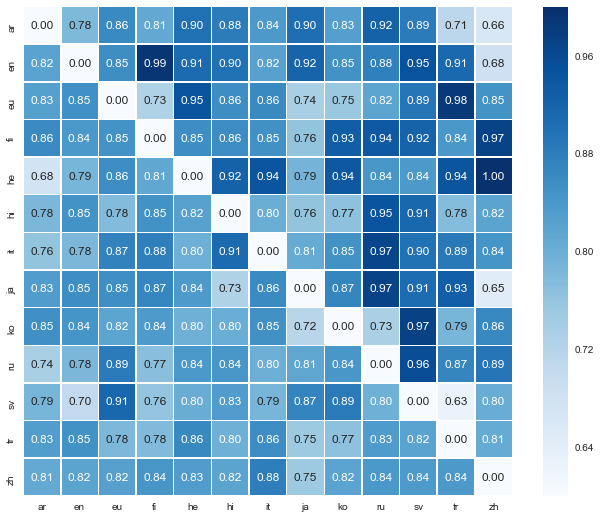

In [15]:
mask = np.triu(np.ones_like(d_emb, dtype=np.bool))
d_emb[mask] = d_e2e[mask]

sns.set(style="white")
d = pd.DataFrame(data=d_emb,
                 columns=sorted(in_language_embedding.keys()), index=sorted(in_language_embedding.keys()))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
    
sns.heatmap(d, vmax=1., vmin=0.6, 
            square=True, annot=True, linewidth = 0.5, cmap='Blues', fmt='0.2f')

plt.savefig('cosine-heats-e2e.pdf', bbox_inches='tight', dpi=300)
plt.show()

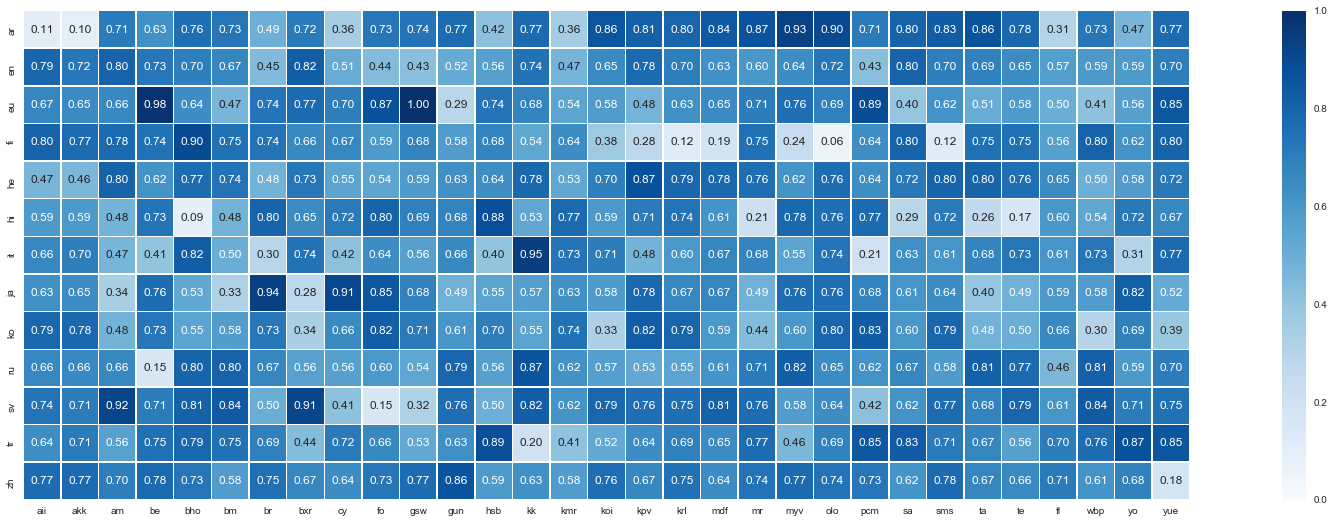

In [19]:
sns.set(style="white")
d = pd.DataFrame(data=lr_d_emb,
                 index=sorted(in_language_embedding.keys()), columns=sorted(oov_language_embedding.keys()))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(33, 9))
    
sns.heatmap(d, vmax=1, vmin=0, 
            square=True, annot=True, linewidth = 0.5, cmap='Blues', fmt='0.2f')



plt.savefig('cosine-heats-lr-emb.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [26]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(languages, embeddings, language_codes, fig_name):
    "Creates and TSNE model and plots it"
    labels = languages
    tokens = embeddings
    
    tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    colorgroup = 13*['r'] + 31*['b']
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i], c=colorgroup[i], label=language_codes[i], s=60)
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     fontsize=22)
    ax = plt.subplot(111)
    box = ax.get_position()
    legend_x = 1.01
    legend_y = 0.5
    plt.legend(loc='center left', bbox_to_anchor=(legend_x, legend_y), fontsize='13')
    plt.savefig(fig_name, bbox_inches='tight', dpi=300)
    plt.show()
    return new_values

/Users/ahmetustun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


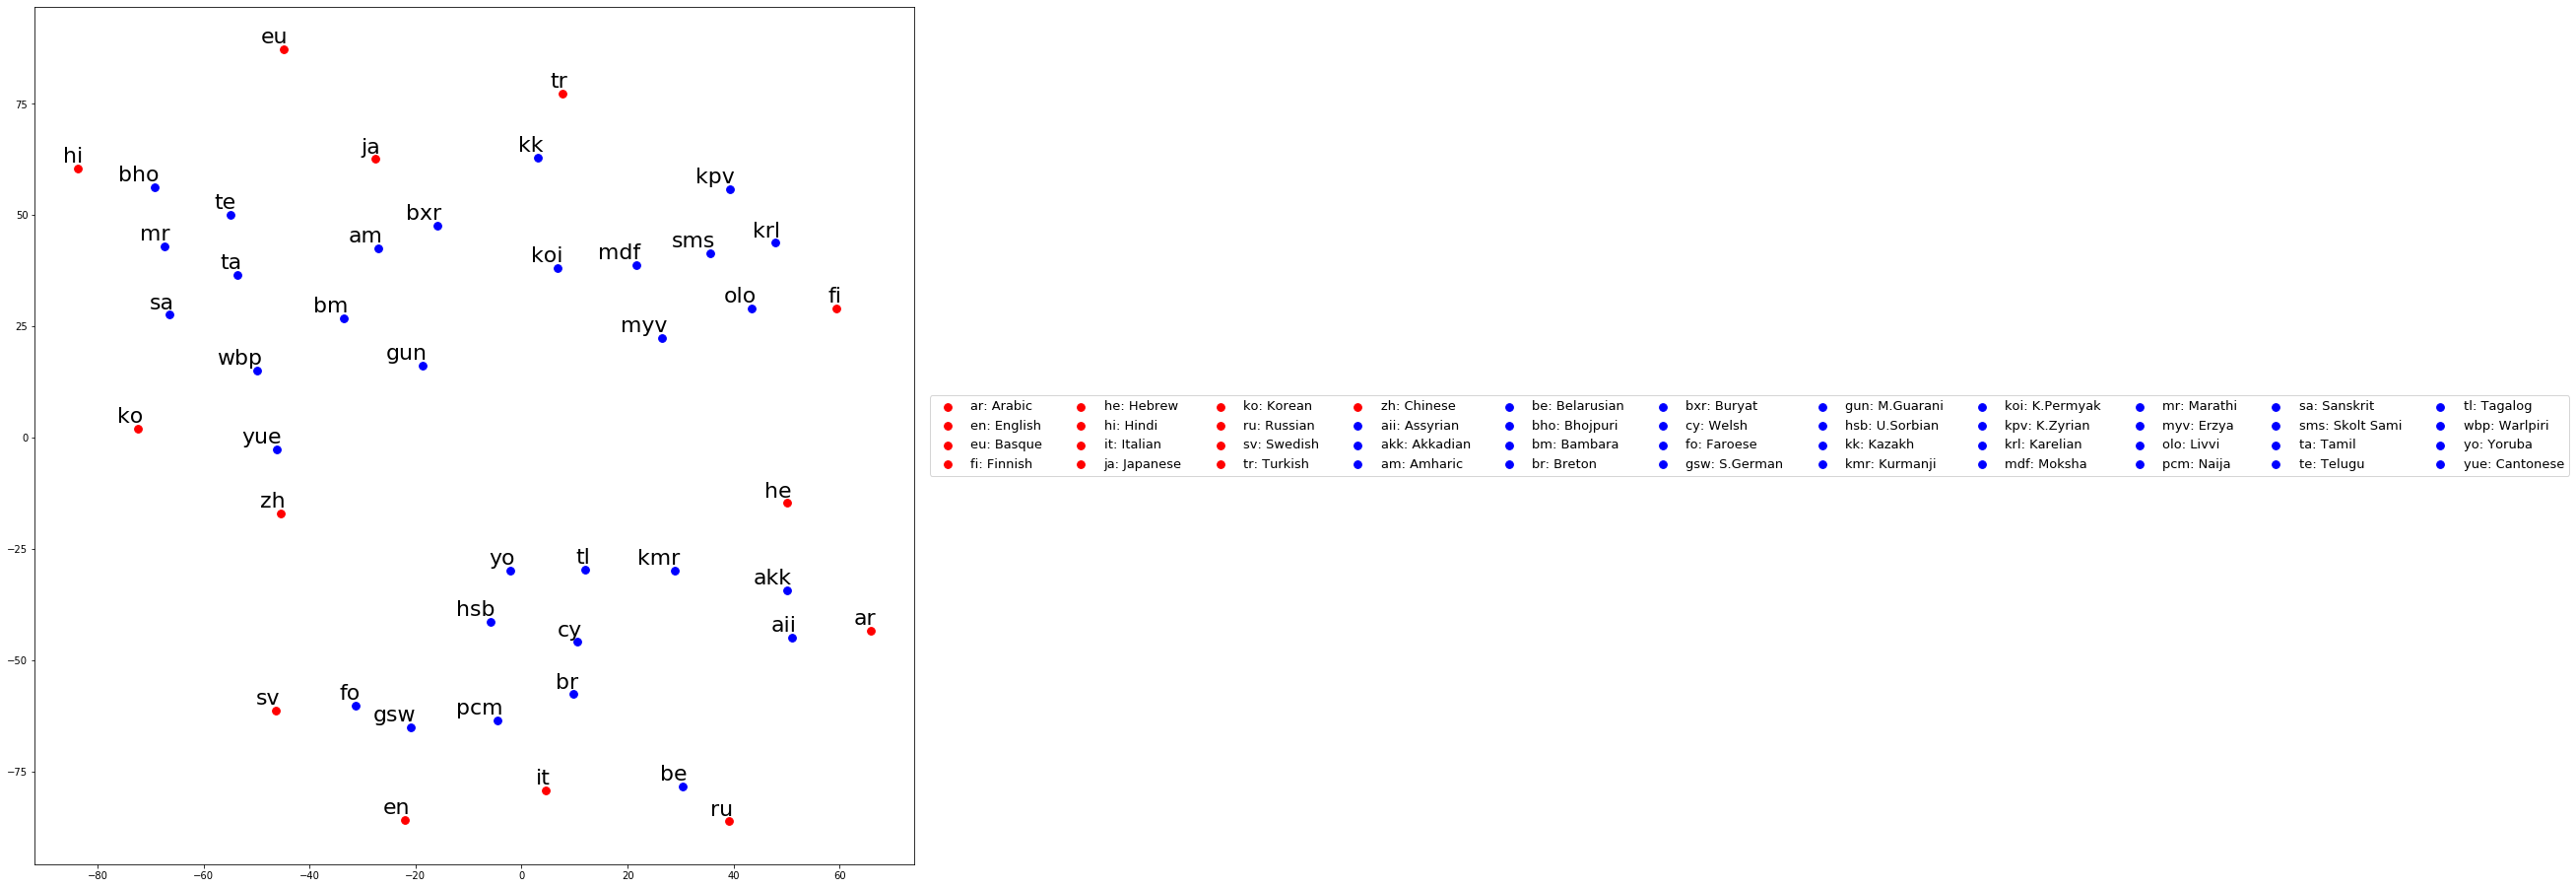

In [25]:
language_emb_2d = tsne_plot(languages, embeddings, lang_codes, 'language_embeddings.png')

/Users/ahmetustun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


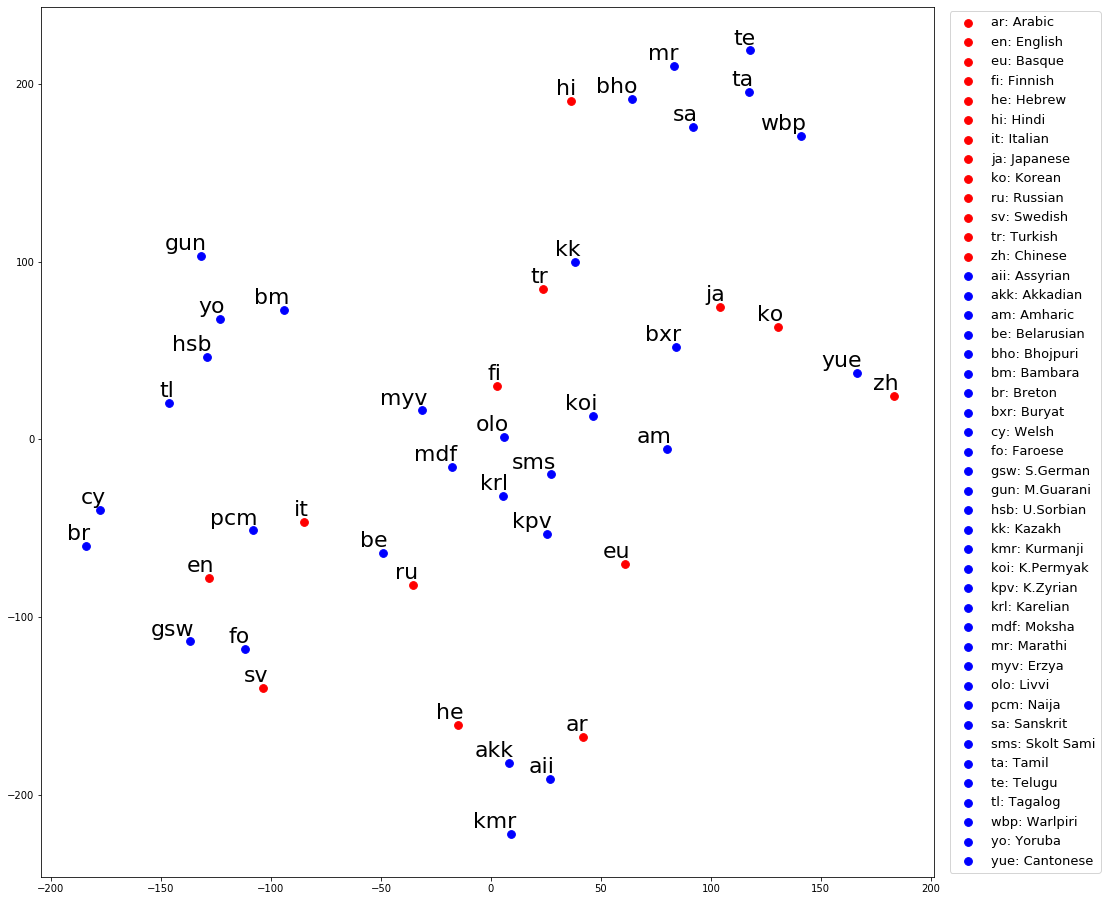

In [30]:
language_feat_2d = tsne_plot(languages, features, lang_codes, 'language_features.png')

/Users/ahmetustun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


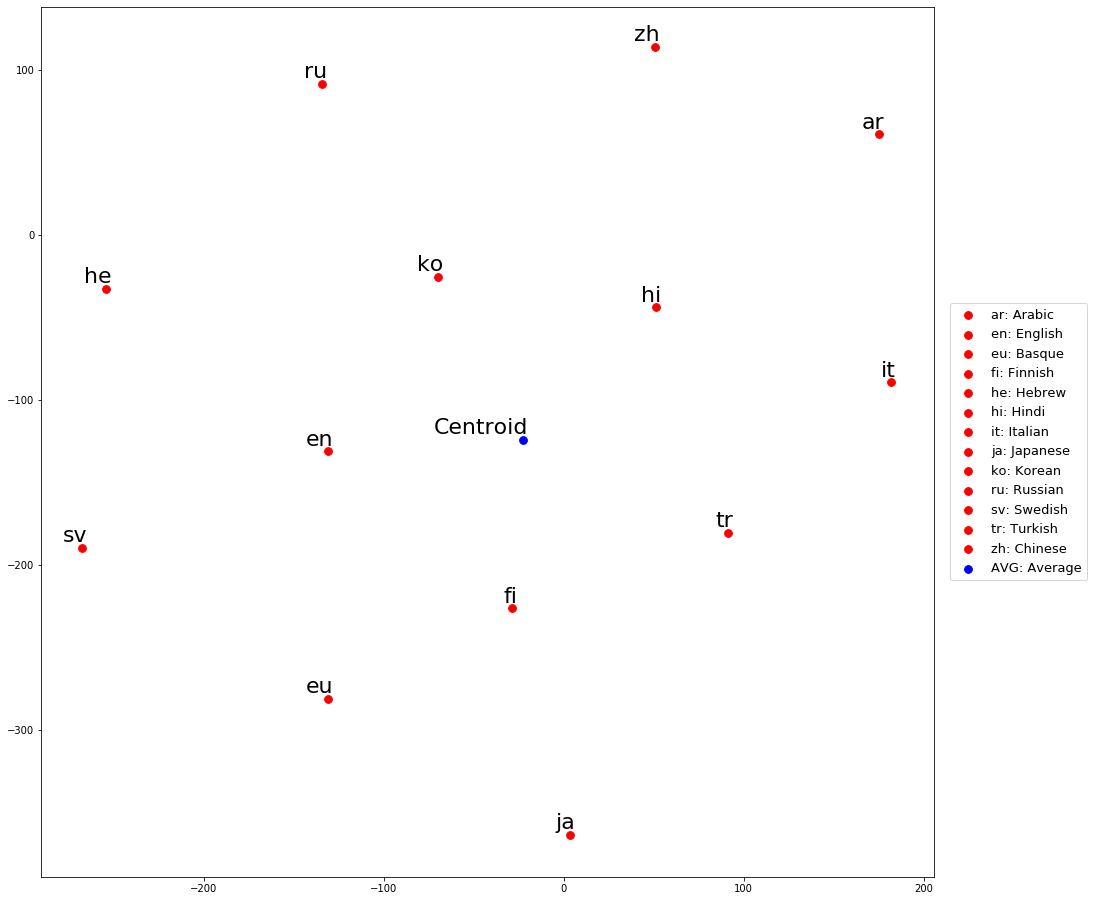

In [12]:
e2e_language_embedding = {lang: language_emb(torch.tensor([in_lang_list.index(lang)])) for lang in in_lang_list}
e2e_avg_embedding = {'AVG': language_emb(torch.tensor([1001]))}

languages_e2e = list(e2e_language_embedding.keys()) + ['Centroid']
embeddings_e2e = [emb.detach().numpy() for emb in e2e_language_embedding.values()] + [emb.detach().numpy() for emb in e2e_avg_embedding.values()]

language_e2e_2d = tsne_plot(languages_e2e, embeddings_e2e, lang_codes[:13]+['AVG: Average'], 'language_e2e.png')

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(language_emb_2d, 'single')

labelList = languages

plt.figure(figsize=(16, 8))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)

plt.savefig('language_clusters.png', bbox_inches='tight')
plt.show()

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(language_feat_2d, 'single')

labelList = languages

plt.figure(figsize=(16, 8))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)

plt.savefig('language_clusters_feat.png', bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

down_projection_weights = language_mlp.nonlinear_project.weight.data
weights = down_projection_weights.abs().sum(dim=0).view(1,-1)

features = l2v.get_features("eng", config.language_features, header=True)
feature_codes = features['CODE']

plt.subplots(figsize=(80, 3))
sns.heatmap(weights.detach().numpy(), yticklabels=False, xticklabels=feature_codes, cmap='Greys')
plt.xlabel("Language embeddings dimensions")
plt.savefig('heatmap_weights_all.png', bbox_inches='tight')

In [36]:
projection_weights = language_mlp.nonlinear_project.weight.data
norm_weights = torch.norm(projection_weights, dim=0, keepdim=True).numpy()
a = norm_weights.squeeze()

x=a
normalized = (x-min(x))/(max(x)-min(x))
normalized

means = [np.mean(a[:102]), np.mean(a[103:130]), np.mean(a[131:])]
std = [np.std(a[:102]), np.std(a[103:130]), np.std(a[131:])]
means

[0.5488218, 0.5439909, 0.54592335]

In [ ]:
most_weighted_features = [feature_codes[i] for i in a]
m_weights = np.sort(weights.detach().numpy())
m_weights = m_weights.squeeze()[-10:]
#print(most_weighted_features)
#print(m_weights)
most_weighted_features

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

down_projection_weights = language_mlp.nonlinear_project.weight.data
weights = down_projection_weights.abs().sum(dim=0).view(1,-1)[:,:103]

features = l2v.get_features("eng", config.language_features, header=True)
feature_codes = features['CODE'][:103]

plt.subplots(figsize=(80, 3))
sns.heatmap(weights.detach().numpy(), yticklabels=False, xticklabels=feature_codes, cmap='Greys')
plt.xlabel("Language embeddings dimensions")
plt.savefig('heatmap_weights_syntax.png', bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

down_projection_weights = language_mlp.down_project.weight.data
weights = down_projection_weights.abs().sum(dim=0).view(1,-1)[:,104:132]

features = l2v.get_features("eng", config.language_features, header=True)
feature_codes = features['CODE'][104:132]

plt.subplots(figsize=(80, 3))
sns.heatmap(weights.detach().numpy(), yticklabels=False, xticklabels=feature_codes, cmap='Greys')
plt.xlabel("Language embeddings dimensions")
plt.savefig('heatmap_weights_phonology.png', bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

down_projection_weights = language_mlp.down_project.weight.data
weights = down_projection_weights.abs().sum(dim=0).view(1,-1)[:,133:]

features = l2v.get_features("eng", config.language_features, header=True)
feature_codes = features['CODE'][133:]

plt.subplots(figsize=(80, 3))
sns.heatmap(weights.detach().numpy(), yticklabels=False, xticklabels=feature_codes, cmap='Greys')
plt.xlabel("Language embeddings dimensions")
plt.savefig('heatmap_weights_inventory.png', bbox_inches='tight')